# Link analysis of Prado Museum Pictures dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tuedsci/amd/blob/main/prado-pagerank-analysis.ipynb)


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark

## Libraries


In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql import types as st

## Setup


In [ ]:
# Please insert your Kaggle credentials to run
os.environ["KAGGLE_USERNAME"] = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
os.environ["KAGGLE_KEY"] = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

In [ ]:
# Init a Spark session
spark = (
    SparkSession.builder.appName("prado")
    .config("spark.driver.memory", "9g")
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.driver.port", "0")
    .master("local[*]")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")

## Download data


In [5]:
# Download dataset
!kaggle datasets download maparla/prado-museum-pictures

Dataset URL: https://www.kaggle.com/datasets/maparla/prado-museum-pictures
License(s): MIT
100% 24.9G/24.9G [05:27<00:00, 123MB/s]
100% 24.9G/24.9G [05:27<00:00, 81.6MB/s]


In [6]:
# Extract only prado.csv from zip
with zipfile.ZipFile("prado-museum-pictures.zip", "r") as z:
    csv_file = next(f for f in z.namelist() if f.lower() == "prado.csv")
    z.extract(csv_file)

In [7]:
# Set path to the data
DATA_PATH = "prado.csv"

## Data exploration


### Load data


In [8]:
prado = spark.read.options(
    header=True,
    inferSchema=True,
    multiLine=True,
    encoding="utf-8",
    escape='"',
).csv(DATA_PATH)

### Inspect data


In [9]:
# Preview data structure
prado.show(1)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+------------+--------------------+--------------------+----------------------------------+---------------------+----------------------+---------------------+-----------------------+-----------------------+-------------------------+---------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+--------------------------------+-----------------------+--------------------+----------------------+-----------------------------------+
|            work_url|      work_image_url|              author|          author_bio|          author_url|           author_id|       work_title|       work_subtitle|work_exposed|    work_description|           work_tags|technical_sheet_numero_de_catalogo|technical_sheet_autor|technical_sheet_titulo|techni

In [10]:
# Check dimensions and unique work urls
print("Num rows: ", prado.count())
print("Num unique work urls: ", prado.select("work_url").distinct().count())

Num rows:  13487
Num unique work urls:  13487


Comment: Number of unique work URLS equals the number of rows, thus `work_url` can be used as identifier. However, it is too cumbersome, and we should hash it for a more concise representation.


In [11]:
# Create node id by hashing work_url
prado = prado.withColumn("node", sf.hash("work_url"))
prado.select("node").show(3)

+-----------+
|       node|
+-----------+
| 2092045149|
|  146135401|
|-1256791983|
+-----------+
only showing top 3 rows



In [12]:
# Explore work tags
prado.select("work_tags").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+
|work_tags                                                                                                                                         |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
|Serie de dibujos para el fresco la Caída de los Gigantes en el Palacio Real de Madrid;Lápiz negro;Papel verdoso;Estudio de cabeza;Mitología;1764;+|
|Sanguina;Papel agarbanzado;Desnudo femenino;Profetas de Israel;Susana;1701;+                                                                      |
|Óleo;Tabla;Retrato civil;Caléndula / Maravilla (Calendula officinalis);Sombrero;1562;+                                                            |
|Óleo;Lienzo;Pescador/es;Peces;1785;González Velázquez, Zacarías;+                                        

Comment: Work tags are separated by semicolons (`;`), and there seems to be an extra `+` sign at the end that needs to be removed.


Now we clean tags and create a data frame of work-tag pairs, each in a separate row.


In [23]:
# Explode and clean tags to make work-tag pairs
work_tag = (
    prado.withColumn("work_tags", sf.regexp_replace("work_tags", r";\+$", ""))
    .withColumn("work_tags", sf.split("work_tags", ";"))
    .withColumn("tag", sf.explode("work_tags"))
    .withColumn("tag", sf.trim("tag"))
    .withColumn("tag", sf.lower(sf.col("tag")))
    .select("node", "tag")
)

work_tag.show(5, False)

+----------+-------------------------------------------------------------------------------------+
|node      |tag                                                                                  |
+----------+-------------------------------------------------------------------------------------+
|2092045149|serie de dibujos para el fresco la caída de los gigantes en el palacio real de madrid|
|2092045149|lápiz negro                                                                          |
|2092045149|papel verdoso                                                                        |
|2092045149|estudio de cabeza                                                                    |
|2092045149|mitología                                                                            |
+----------+-------------------------------------------------------------------------------------+
only showing top 5 rows



In [24]:
# Count unique works and tags
print("Num unique works: ", work_tag.select("node").distinct().count())
print("Num unique tags: ", work_tag.select("tag").distinct().count())

Num unique works:  13487
Num unique tags:  3545


Explore tag distribution


In [25]:
tag_dist = work_tag.groupBy("tag").agg(sf.count("node").alias("n_works"))

# Top 5 tags with most works
print("Top 5 tags with most works")
tag_dist.orderBy(sf.desc("n_works")).show(5, False)

# Top 5 tags with least works
print("Top 5 tags with least works")
tag_dist.orderBy(sf.asc("n_works")).show(5, False)

Top 5 tags with most works
+---------------+-------+
|tag            |n_works|
+---------------+-------+
|óleo           |4177   |
|lienzo         |3225   |
|pluma          |1923   |
|papel verjurado|1477   |
|lápiz negro    |1248   |
+---------------+-------+
only showing top 5 rows

Top 5 tags with least works
+--------------------+-------+
|tag                 |n_works|
+--------------------+-------+
|pérez rubio, antonio|1      |
|1512                |1      |
|taller ático        |1      |
|-4                  |1      |
|1572                |1      |
+--------------------+-------+
only showing top 5 rows



Comment: There are tags shared by many works, which is expected since they are popular keywords in art, such as Óleo (Oil), Lienzo (Canvas), Pluma (Pen), etc.


Explore artwork distribution


In [26]:
work_dist = work_tag.groupBy("node").agg(sf.count("tag").alias("n_tags"))

# Top 5 works with most tags
print("Top 5 works with most tags")
work_dist.orderBy(sf.desc("n_tags")).show(5, False)

# Top 5 works with least tags
print("Top 5 works with least tags")
work_dist.orderBy(sf.asc("n_tags")).show(5, False)

Top 5 works with most tags
+-----------+------+
|node       |n_tags|
+-----------+------+
|-1094470655|7     |
|1928626632 |7     |
|1901392218 |7     |
|-320645666 |7     |
|-1027224108|7     |
+-----------+------+
only showing top 5 rows

Top 5 works with least tags
+-----------+------+
|node       |n_tags|
+-----------+------+
|-2034788158|4     |
|151895471  |4     |
|447748375  |4     |
|-316059076 |4     |
|928859623  |4     |
+-----------+------+
only showing top 5 rows



Comment: This seems reasonable, as the number of tags per work is not too high (ranging from 4 to 7 tags per work).


## Functions


Based on previous analysis, we can define several functions to clean and extract relevant data for our analysis. We also implement a function to compute the PageRank of the nodes in the artwork network.


In [27]:
def load_csv(spark, data_path, test_rows=None):
    """
    Load data from a csv file.
    Returns a DataFrame.
    """
    # Load data
    df = spark.read.options(
        header=True,
        inferSchema=True,
        multiLine=True,
        encoding="utf-8",
        escape='"',
    ).csv(data_path)

    # Rename work_url to id
    df = df.withColumn("node", sf.hash("work_url"))

    # Limit number of rows for testing
    if test_rows:
        df = df.limit(test_rows)

    return df

In [28]:
def create_work_tag_pairs(df):
    """
    Create work-tag pairs by splitting and cleaning work tags from a DataFrame.
    Returns a DataFrame with columns 'id' and 'tag' containing unique work-tag pairs.
    """
    # Remove ';+' at the end of the string and split by ';'
    # then explode work tags and trim whitespaces
    df = (
        df.withColumn("work_tags", sf.regexp_replace("work_tags", r";\+$", ""))
        .withColumn("work_tags", sf.split("work_tags", ";"))
        .withColumn("tag", sf.explode("work_tags"))
        .withColumn("tag", sf.expr("lower(trim(tag))"))
    )

    # Select relevant columns, remove duplicates, and return
    return df.select("node", "tag").distinct()

In [29]:
def create_edge_list(df, node_col, attr_col):
    """
    Create an edge list of node-node pairs based on a shared attribute.
    Returns a DataFrame with columns 'src' and 'dst' representing unique node pairs.
    """
    # Create source and destination data frames
    src_df = df.select(sf.col(node_col).alias("src"), sf.col(attr_col).alias("attr"))
    dst_df = df.select(sf.col(node_col).alias("dst"), sf.col(attr_col).alias("attr"))

    # Join on shared attribute column and remove self loops (src != dst)
    edge_list = (
        src_df.join(dst_df, on="attr", how="inner")
        .where(sf.col("src") != sf.col("dst"))
        .select("src", "dst")
        .distinct()
    )

    return edge_list

In [30]:
def compute_pagerank(
    nodes,
    edges,
    topic_nodes=None,
    max_iter=10,
    beta=0.85,
    tol=1e-4,
    verbose=True,
):
    """
    Compute PageRank scores for nodes in a graph.

    Args:
        nodes: node data frame with two column `src` (id of node) and `out_deg`
        (out-degree of node)
        edges: edge data frame with two column `src` (source node id) and `dst`
        (destination node id)
        max_iter: maximum number of iterations
        beta: damping factor
        tol: convergence threshold
        verbose: print progress

    Returns:
        A data frame with columns `node` and `rank` sorted by rank in descending order
    """
    # Init
    n = nodes.count()
    pr = nodes.withColumn("rank", sf.lit(1 / n)).select("node", "rank")
    if topic_nodes is not None:
        n_topic = topic_nodes.count()

    # Iterate to update ranks
    deltas = []
    for i in range(max_iter):
        # Compute contribution of each node to its neighbors
        # Nodes with no out-degree will have contrib zero
        contrib = (
            nodes.join(pr, on="node", how="inner")
            .withColumn("contrib", sf.expr("rank / out_deg"))
            .selectExpr("node as src", "contrib")
            .fillna(0)
        )

        # Update ranks for nodes that have incoming edges
        pr_new = (
            edges.join(contrib, on="src", how="inner")
            .groupBy("dst")
            .agg(sf.sum("contrib").alias("rank_new"))
            .selectExpr("dst as node", "rank_new")
        )

        # Add nodes with no incoming edges with zero rank
        pr_new = (
            nodes.join(pr_new, on="node", how="left")
            .select("node", "rank_new")
            .fillna(0)
        )

        # Re-distribute rank leakage uniformly to all nodes
        leakage = max(1 - pr_new.agg(sf.sum("rank_new")).collect()[0][0], 0)
        pr_new = pr_new.withColumn("rank_new", sf.col("rank_new") + leakage / n)

        # Update ranks with teleportation
        if topic_nodes is None:
            pr_new = pr_new.withColumn(
                "rank_new", beta * sf.col("rank_new") + (1 - beta) / n
            )
        else:
            pr_new = pr_new.join(
                sf.broadcast(topic_nodes), on="node", how="left"
            ).withColumn(
                "rank_new",
                beta * sf.col("rank_new")
                + (1 - beta)
                * sf.when(sf.col("rank_new").isNotNull(), 1 / n_topic).otherwise(0),
            )

        # Compute L2 norm of old and new rank differences
        delta = (
            pr.join(pr_new, on="node")
            .agg(sf.expr("sqrt(sum(pow(rank - rank_new, 2)))"))
            .collect()[0][0]
        )
        delta = round(delta, 6)
        deltas.append(delta)

        # Print progress
        if verbose:
            print(f"Iteration {i + 1}, delta={delta}")

        # Update ranks
        pr = pr_new.withColumnRenamed("rank_new", "rank")

        # Check convergence
        if delta < tol:
            break

    return pr.orderBy(sf.desc("rank")), deltas

In [31]:
def plot_convergence(deltas, figsize=(7, 4), save_path=None, show=True):
    """
    Plot the convergence of PageRank scores.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(deltas, marker="o")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("L2-norm of rank difference")
    ax.set_title("PageRank convergence")
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    if show:
        plt.show()

## Experiments


Step 0: Config


In [38]:
TEST_ROWS = 1_000
BETA = 0.85
MAX_ITER = 20
TOL = 1e-4

Step 1: Load original data


In [39]:
data = load_csv(spark, DATA_PATH, test_rows=TEST_ROWS)

Step 2: Create work-tag pairs.


In [40]:
# Prepare work:tag pairs
work_tag = create_work_tag_pairs(data)
work_tag.show(1)

+----------+--------------------+
|      node|                 tag|
+----------+--------------------+
|2092045149|serie de dibujos ...|
+----------+--------------------+
only showing top 1 row



Step 3: Create (and cache) data frame of edges of work-work pairs.


In [41]:
if "edges" in locals():
    locals()["edges"].unpersist()

edges = create_edge_list(work_tag, node_col="node", attr_col="tag").cache()

print(edges.count())
edges.show(1)

205388
+----------+-----------+
|       src|        dst|
+----------+-----------+
|2092045149|-1145844827|
+----------+-----------+
only showing top 1 row



Step 4: Create (and cache) data frame of all nodes with out-degrees


In [42]:
# Get all nodes
if "nodes" in locals():
    locals()["nodes"].unpersist()

nodes = (
    data.select("node")
    .join(edges.withColumnRenamed("src", "node"), on="node", how="left")
    .groupBy("node")
    .agg(sf.count("dst").alias("out_deg"))
    .cache()
)

print(nodes.count())
nodes.show(1)

1000
+----------+-------+
|      node|out_deg|
+----------+-------+
|2092045149|    131|
+----------+-------+
only showing top 1 row



Step 5: Compute general PageRank scores


In [43]:
pr, deltas = compute_pagerank(
    nodes,
    edges,
    topic_nodes=None,
    max_iter=MAX_ITER,
    beta=BETA,
    tol=TOL,
    verbose=True,
)

Iteration 1, delta=0.00697
Iteration 2, delta=0.002105
Iteration 3, delta=0.001094
Iteration 4, delta=0.000683
Iteration 5, delta=0.000463
Iteration 6, delta=0.000328
Iteration 7, delta=0.000238
Iteration 8, delta=0.000176
Iteration 9, delta=0.000131
Iteration 10, delta=9.8e-05


Step 6: Compute topic-specific PageRank scores for two example tags: `óleo`and `pluma`.


In [53]:
topics = [
    "óleo",  # oil
    "pluma",  # feather
]

prts_dict = {}
delta_dict = {}
for tag in topics:
    topic_nodes = work_tag.where(f"tag = '{tag}'").select("node")
    print(f"""\nTopic: {tag}, Num nodes: {topic_nodes.count()}""")

    p, d = compute_pagerank(
        nodes,
        edges,
        topic_nodes=topic_nodes,
        max_iter=MAX_ITER,
        beta=BETA,
        tol=TOL,
        verbose=True,
    )

    prts_dict[tag] = p
    delta_dict[tag] = d


Topic: óleo, Num nodes: 328
Iteration 1, delta=0.011959
Iteration 2, delta=0.009007
Iteration 3, delta=0.007631
Iteration 4, delta=0.006497
Iteration 5, delta=0.00554
Iteration 6, delta=0.004725
Iteration 7, delta=0.004031
Iteration 8, delta=0.003437
Iteration 9, delta=0.002931
Iteration 10, delta=0.002498
Iteration 11, delta=0.002129
Iteration 12, delta=0.001814
Iteration 13, delta=0.001545
Iteration 14, delta=0.001316
Iteration 15, delta=0.00112
Iteration 16, delta=0.000954
Iteration 17, delta=0.000812
Iteration 18, delta=0.000691
Iteration 19, delta=0.000588
Iteration 20, delta=0.0005

Topic: pluma, Num nodes: 133
Iteration 1, delta=0.031697
Iteration 2, delta=0.027459
Iteration 3, delta=0.023618
Iteration 4, delta=0.020262
Iteration 5, delta=0.017352
Iteration 6, delta=0.014842
Iteration 7, delta=0.012684
Iteration 8, delta=0.010832
Iteration 9, delta=0.009246
Iteration 10, delta=0.007889
Iteration 11, delta=0.006728
Iteration 12, delta=0.005736
Iteration 13, delta=0.004889
Iterat

Step 7: Convert PageRank scores to Pandas and combine them for further analysis.


In [54]:
df_list = [
    pr.withColumnRenamed("rank", "pr").toPandas(),
    prts_dict["óleo"].withColumnRenamed("rank", "prts_oleo").toPandas(),
    prts_dict["pluma"].withColumnRenamed("rank", "prts_pluma").toPandas(),
]

pr_all = df_list[0].copy()
for df in df_list[1:]:
    pr_all = pr_all.merge(df, on="node")

pr_all.head(1)

,node,pr,prts_oleo,prts_pluma
0,-734415877,0.001847,0.005442,0.013322


Step 8: Combine deltas for further analysis.


In [55]:
def create_iter_df(array, name):
    s = pd.Series(array)
    return pd.DataFrame({"iteration": s.index, name: s})


df_list = [
    create_iter_df(deltas, "pr"),
    create_iter_df(delta_dict["óleo"], "prts_oleo"),
    create_iter_df(delta_dict["pluma"], "prts_pluma"),
]

delta_all = df_list[0].copy()
for df in df_list[1:]:
    delta_all = delta_all.merge(df, on="iteration", how="outer")

delta_all.head(1)

,iteration,pr,prts_oleo,prts_pluma
0,0,0.00697,0.011959,0.031697


## Analysis of results


### Convergence progress


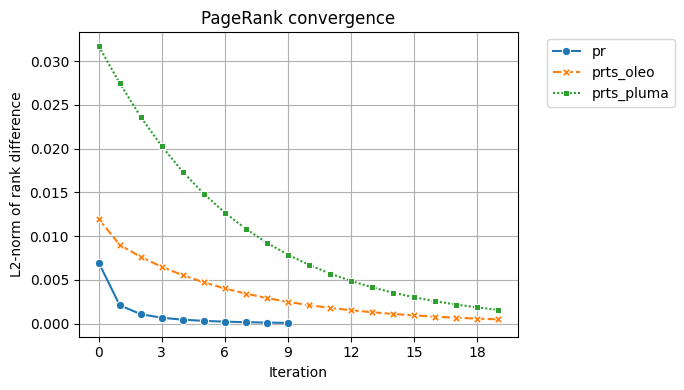

In [56]:
# Prepare plot data
plt_data = delta_all.melt(id_vars="iteration", var_name="pr_type", value_name="delta")

# Plot convergence
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(
    data=plt_data,
    x="iteration",
    y="delta",
    hue="pr_type",
    style="pr_type",
    markers=True,
    ax=ax,
)

ax.set_xlabel("Iteration")
ax.set_ylabel("L2-norm of rank difference")
ax.set_title("PageRank convergence")
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.legend(title="PageRank type")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()

### Comparision with NetworkX


In [57]:
# Create a networkx graph
edges_pd = edges.toPandas()
nodes_list = [row[0] for row in nodes.select("node").collect()]

G = nx.from_pandas_edgelist(edges_pd, source="src", target="dst")
G.add_nodes_from(nodes_list)

In [58]:
# Compute PageRank using networkx and join with spark results
pr_nx = nx.pagerank(G, alpha=0.85)
pr_nx = pd.DataFrame(pr_nx.items(), columns=["node", "pr_nx"])
pr_all_nx = pr_all.merge(pr_nx, on="node")

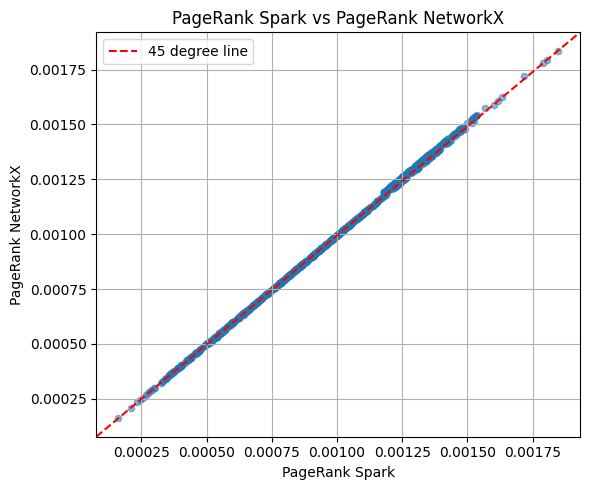

In [59]:
# Plot scatter plot for correlation
fig, ax = plt.subplots(figsize=(6, 5))
pr_all_nx.plot.scatter(x="pr", y="pr_nx", ax=ax, alpha=0.5)
ax.set_title("PageRank Spark vs PageRank NetworkX")
ax.set_xlabel("PageRank Spark")
ax.set_ylabel("PageRank NetworkX")
plt.plot(
    [0, 1],
    [0, 1],
    transform=ax.transAxes,
    ls="--",
    color="red",
    label="45 degree line",
)
plt.tight_layout()
plt.legend()
plt.grid(True)

plt.show()

In [60]:
# Compute L2 norm of difference
pr_all_nx.apply(lambda x: (x["pr"] - x["pr_nx"]) ** 2, axis=1).sum()

4.136002541481083e-08

### PageRank scores correlation


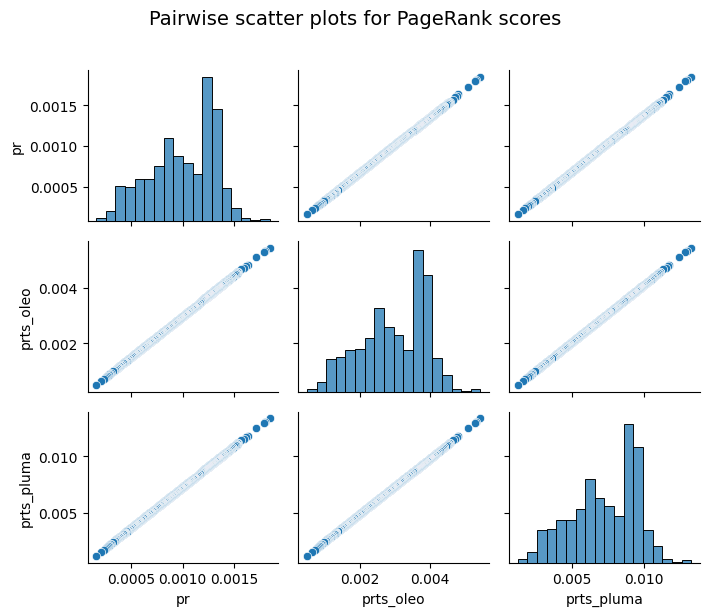

In [61]:
# Plot pairwise scatter plots  for PageRank scores
cols = [
    "pr",
    "prts_oleo",
    "prts_pluma",
]
plt_data = pr_all[cols]
g = sns.pairplot(plt_data, height=2, aspect=1.2)
g.fig.suptitle("Pairwise scatter plots for PageRank scores", y=1.02, fontsize=14)
plt.tight_layout()

plt.show()

In [66]:
# Pearson correlation
pr_all[cols].corr(method="pearson")

,pr,prts_oleo,prts_pluma
pr,1.000000,0.999912,0.999950
prts_oleo,0.999912,1.000000,0.999992
prts_pluma,0.999950,0.999992,1.000000
